In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import notebooks.movielens.twosf_solver as solver
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy import stats
from collections import Counter
import json

import pandas as pd
from collections import defaultdict

In [7]:
def sample_utility(m, n, sample_m,sample_n,W):
    rng = np.random.default_rng()

    users = rng.choice(m, size=sample_m, replace=False)
    items = rng.choice(n, size=sample_n, replace=False)
    return W[users][:,items]

def sample_users_from_groups(users_count: int, items_count: int, groups_map: dict[int, str], group_name: str, data: np.ndarray) -> tuple[np.ndarray, list[int]]:
    users_per_group = {group: max(round(users_count * count / len(groups_map)), 1) for group, count in Counter([i[group_name] for i in groups_map]).items()}
    group_users = defaultdict(list)
    for row in groups_map:
        group_users[row[group_name]].append(row["user_id"])

    sampled_users = []
    for group, users in group_users.items():
        sampled_users.extend(np.random.choice(users, users_per_group[group], replace=False))

    rng = np.random.default_rng()
    items = rng.choice(data.shape[1], size=items_count, replace=False)

    return data[sampled_users][:, items], sampled_users


def get_curves(W, M,N, sample_m, sample_n, num_curves, num_pts, k, delta):
    all_empirical_pairs = []
    for i in tqdm(range(num_curves)):
        # randomly select sample_m authors and sample_n papers
        U = sample_utility(M,N,sample_m,sample_n,W)

        # compute tradeoff curves
        pairs = solver.get_user_curve(U,k,delta,num_pts)
        all_empirical_pairs.append(pairs)

    return np.array(all_empirical_pairs)

def get_curves_user_groups(W, sample_m, sample_n, num_curves, num_pts, k, delta, groups_map: list[dict[str, int]], group_name: str):
    all_empirical_pairs = []
    users_ids = []
    u_utils = []
    for i in tqdm(range(num_curves)):
        U, _users_ids = sample_users_from_groups(sample_m, sample_n, groups_map, group_name, W)
        users_ids.append(_users_ids)

        pairs, _u_utils = solver.get_user_curve(U,k,delta,num_pts)

        u_utils.append(_u_utils)
        all_empirical_pairs.append(pairs)

    return np.array(all_empirical_pairs), users_ids, u_utils

def plot_curves(all_empirical_pairs, num_curves, sample_m, top_k):
    gammas = all_empirical_pairs[0,:,0]
    mean_tradeoff = np.mean(all_empirical_pairs[:,:,1], axis=0)
    std_tradeoff = np.std(all_empirical_pairs[:,:,1], axis=0, ddof=1)
    plt.figure(figsize=(10,6), dpi=300)
    plt.plot(gammas, mean_tradeoff, color='blue')
    plt.fill_between(gammas, mean_tradeoff - 2*std_tradeoff / np.sqrt(num_curves), mean_tradeoff + 2*std_tradeoff / np.sqrt(num_curves), color='blue', alpha=0.2)

    plt.ylabel('Normalized user utility')
    plt.xlabel(r'Fraction of best min normalized item utility guaranteed, $\gamma^I$')
    plt.legend()
    plt.ylim([0,1.1])
    plt.title(f"Tradeoff curve (top_k={top_k}, group size={sample_m}, n-draws={num_curves})")
    plt.savefig(f"./media_1/tradeoff_curves_topk_{top_k}_{num_curves}_and_{sample_m}_users.png")

def plot_p_vals(all_empirical_pairs, all_p_vals, num_curves, sample_m, top_k):
    gammas = all_empirical_pairs[0,:,0]
    mean_pvals = np.mean(all_p_vals, axis=0)
    std_pvals = np.std(all_p_vals, axis=0)
    plt.figure(figsize=(10,6), dpi=300)
    plt.plot(gammas, mean_pvals, color='red')
    plt.fill_between(gammas, mean_pvals - 2*std_pvals / np.sqrt(num_curves), mean_pvals + 2*std_pvals / np.sqrt(num_curves), color='red', alpha=0.2)
    plt.title(f"Item fairness effect to user group fairness (top_k={top_k}, group size={sample_m}, n-draws={num_curves})")
    plt.ylabel('ks-test uniform distribution p-value')
    plt.xlabel(r'Fraction of best min normalized item utility guaranteed, $\gamma^I$')
    plt.savefig(f"./media_1/item_fairness_effect_user_group_fairness_topk{top_k}_group_size{sample_m}_n_draws{num_curves}.png")

def plot_stds(all_empirical_pairs, all_std_vals, num_curves, sample_m, top_k):
    gammas = all_empirical_pairs[0,:,0]
    mean_std_vals = np.mean(all_std_vals, axis=0)
    std_std_vals = np.std(all_std_vals, axis=0)
    plt.figure(figsize=(10,6), dpi=300)
    plt.plot(gammas, mean_std_vals, color='green')
    plt.fill_between(gammas, mean_std_vals - 2*std_std_vals / np.sqrt(num_curves), mean_std_vals + 2*std_std_vals / np.sqrt(num_curves), color='green', alpha=0.2)
    plt.title(f"Item fairness effect to user group fairness(top_k={top_k}, group size={sample_m}, n-draws={num_curves})")
    plt.ylabel('Standard deviation of users utility')
    plt.xlabel(r'Fraction of best min normalized item utility guaranteed, $\gamma^I$')
    plt.savefig(f"./media_1/std_user_utility_topk{top_k}_group_size{sample_m}_n_draws{num_curves}.png")

In [5]:
with open("predictions.npy", "rb") as f:
    W = np.load(f)

with open("user_groups.json", "r") as f:
    user_groups = json.load(f)

M = W.shape[0]
N = W.shape[1]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [07:22<00:00, 147.44s/it]
/var/folders/9l/_y964wyn5fx6bcqmbqjpd9780000gp/T/ipykernel_83583/1047059120.py:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


(0.0, 1.1)

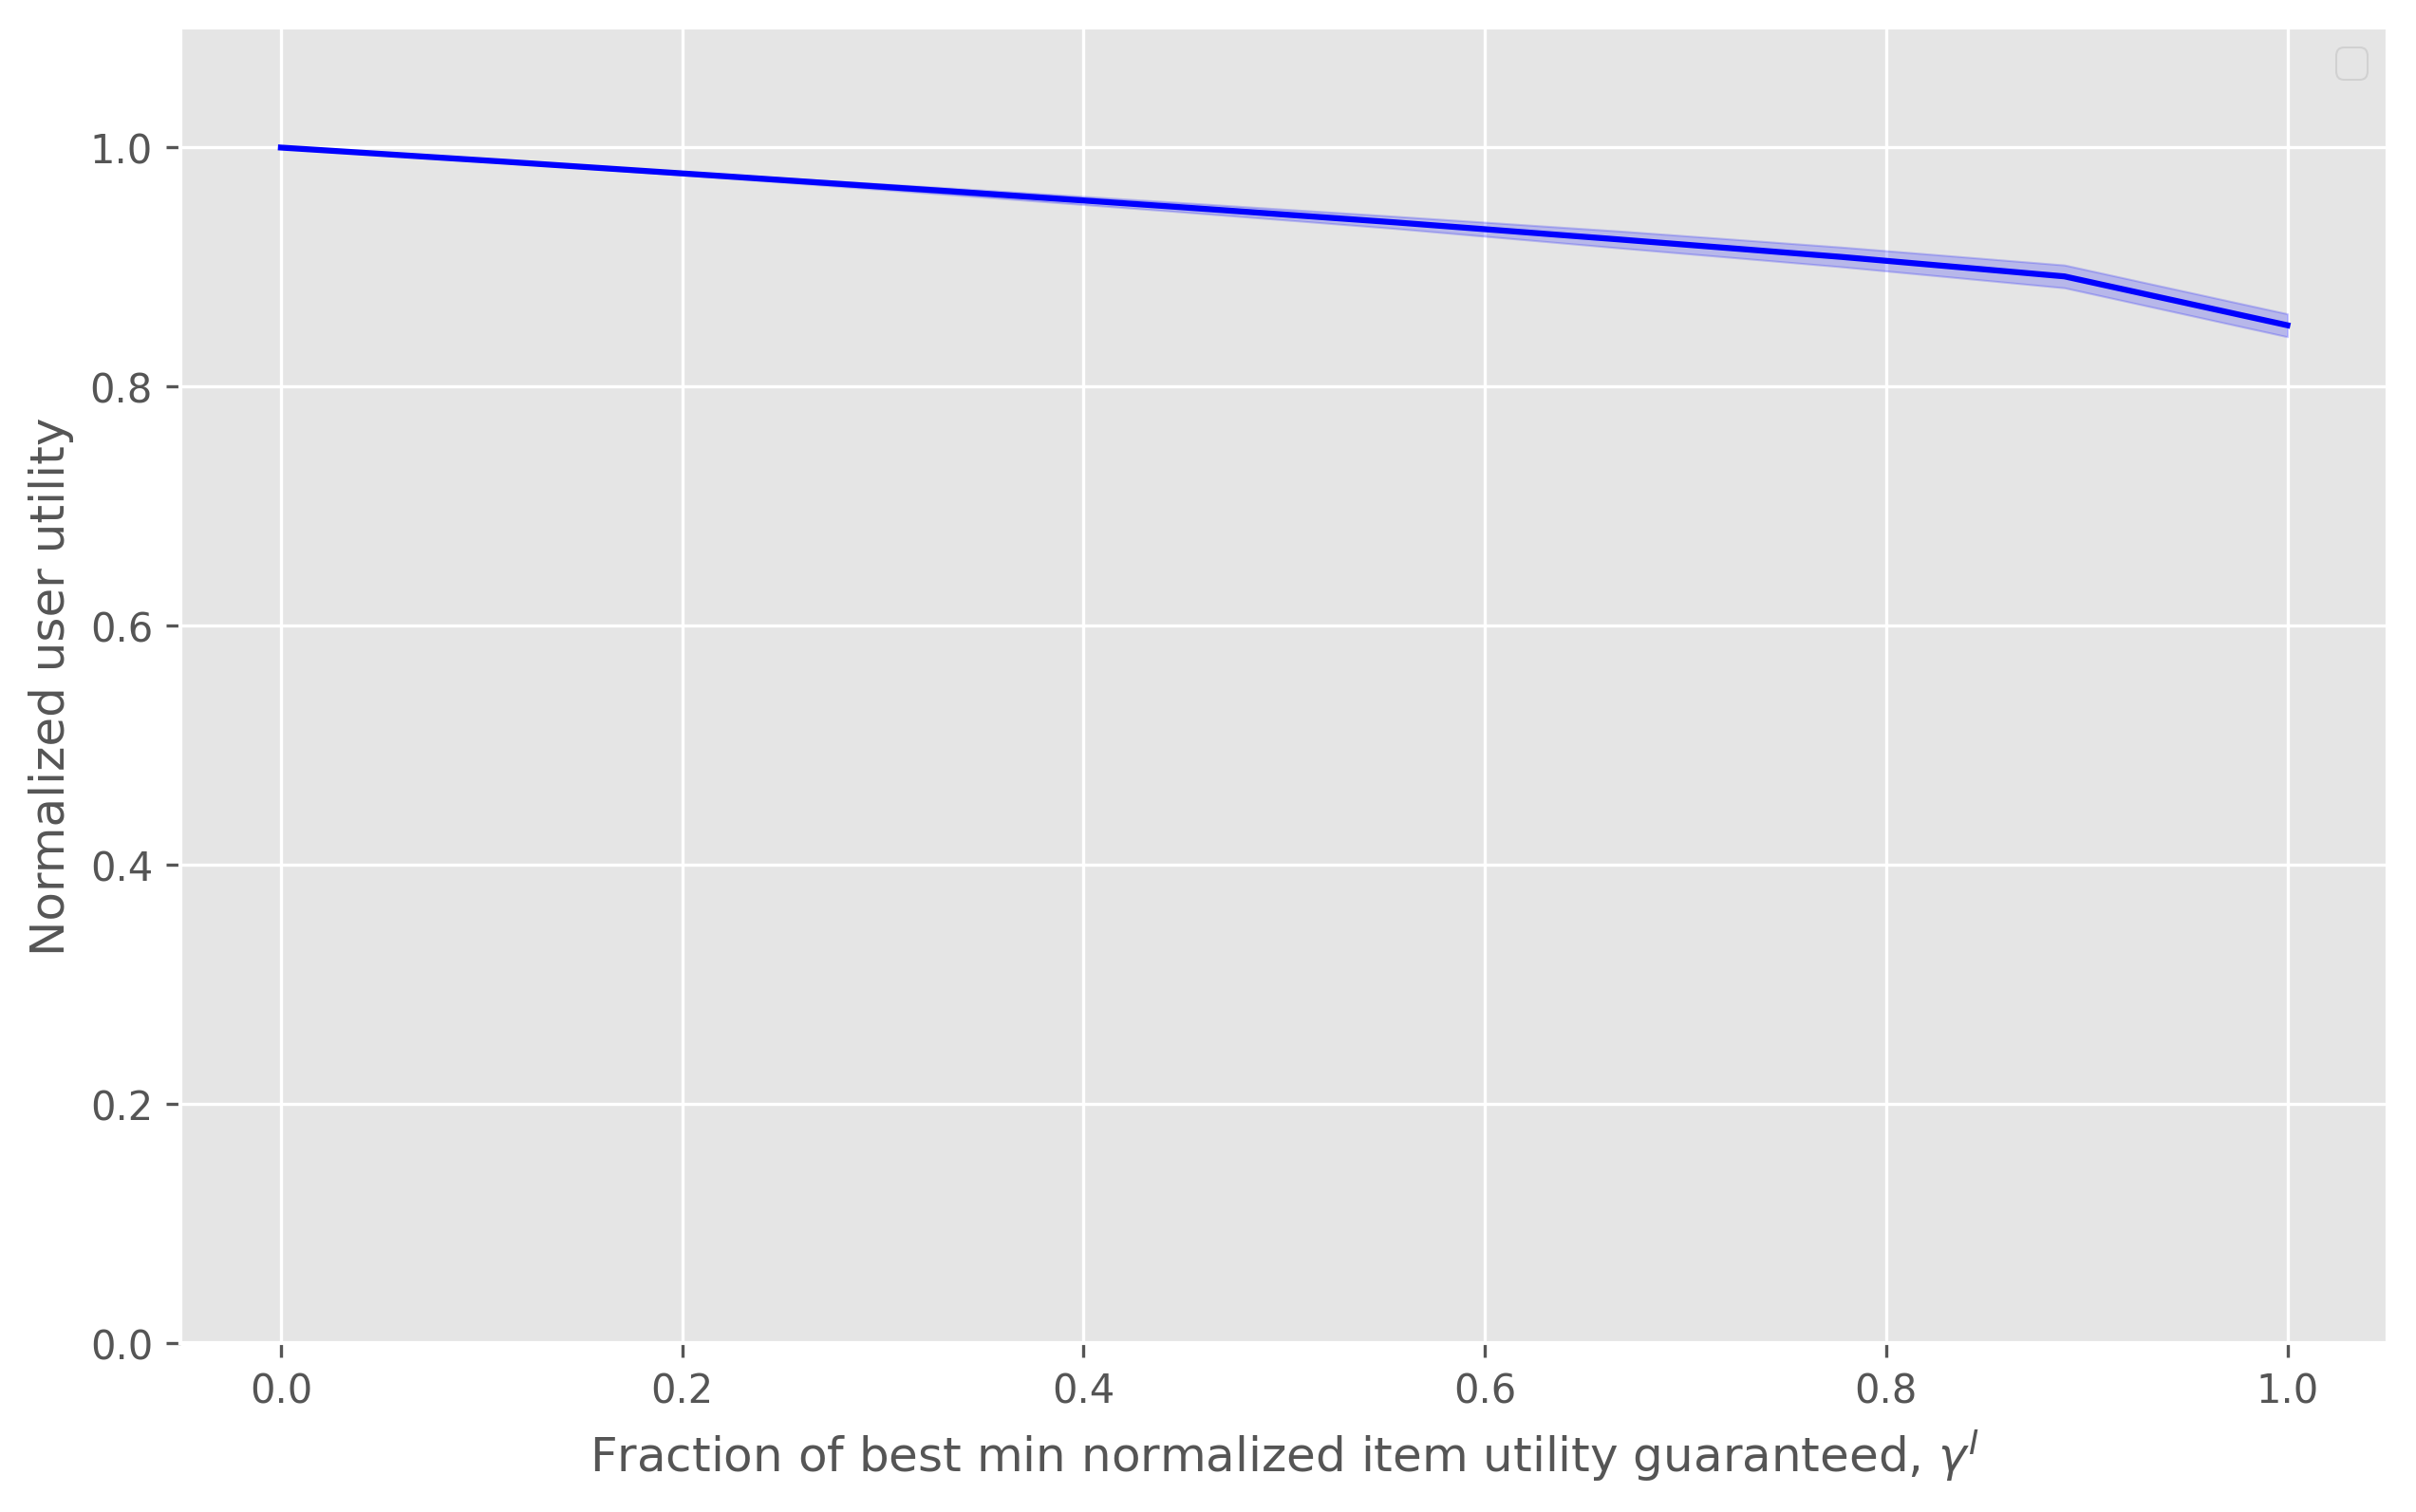

In [ ]:
plt.style.use('ggplot')

sample_n = 50
num_curves = 3
num_pts = 10
user_size = 300
delta = 1
k = 1

all_empirical_pairs = get_curves(W, M, N, user_size, sample_n, num_curves, num_pts, k, delta)

gammas = all_empirical_pairs[0,:,0]
mean_tradeoff = np.mean(all_empirical_pairs[:,:,1], axis=0)
std_tradeoff = np.std(all_empirical_pairs[:,:,1], axis=0, ddof=1)

#plt.title(f"Tradeoff curve (top_k={top_k}, group size={sample_m}, n-draws={num_curves})")
#plt.savefig(f"./media_1/tradeoff_curves_topk_{top_k}_{num_curves}_and_{sample_m}_users.png")


/var/folders/9l/_y964wyn5fx6bcqmbqjpd9780000gp/T/ipykernel_83583/2893685646.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


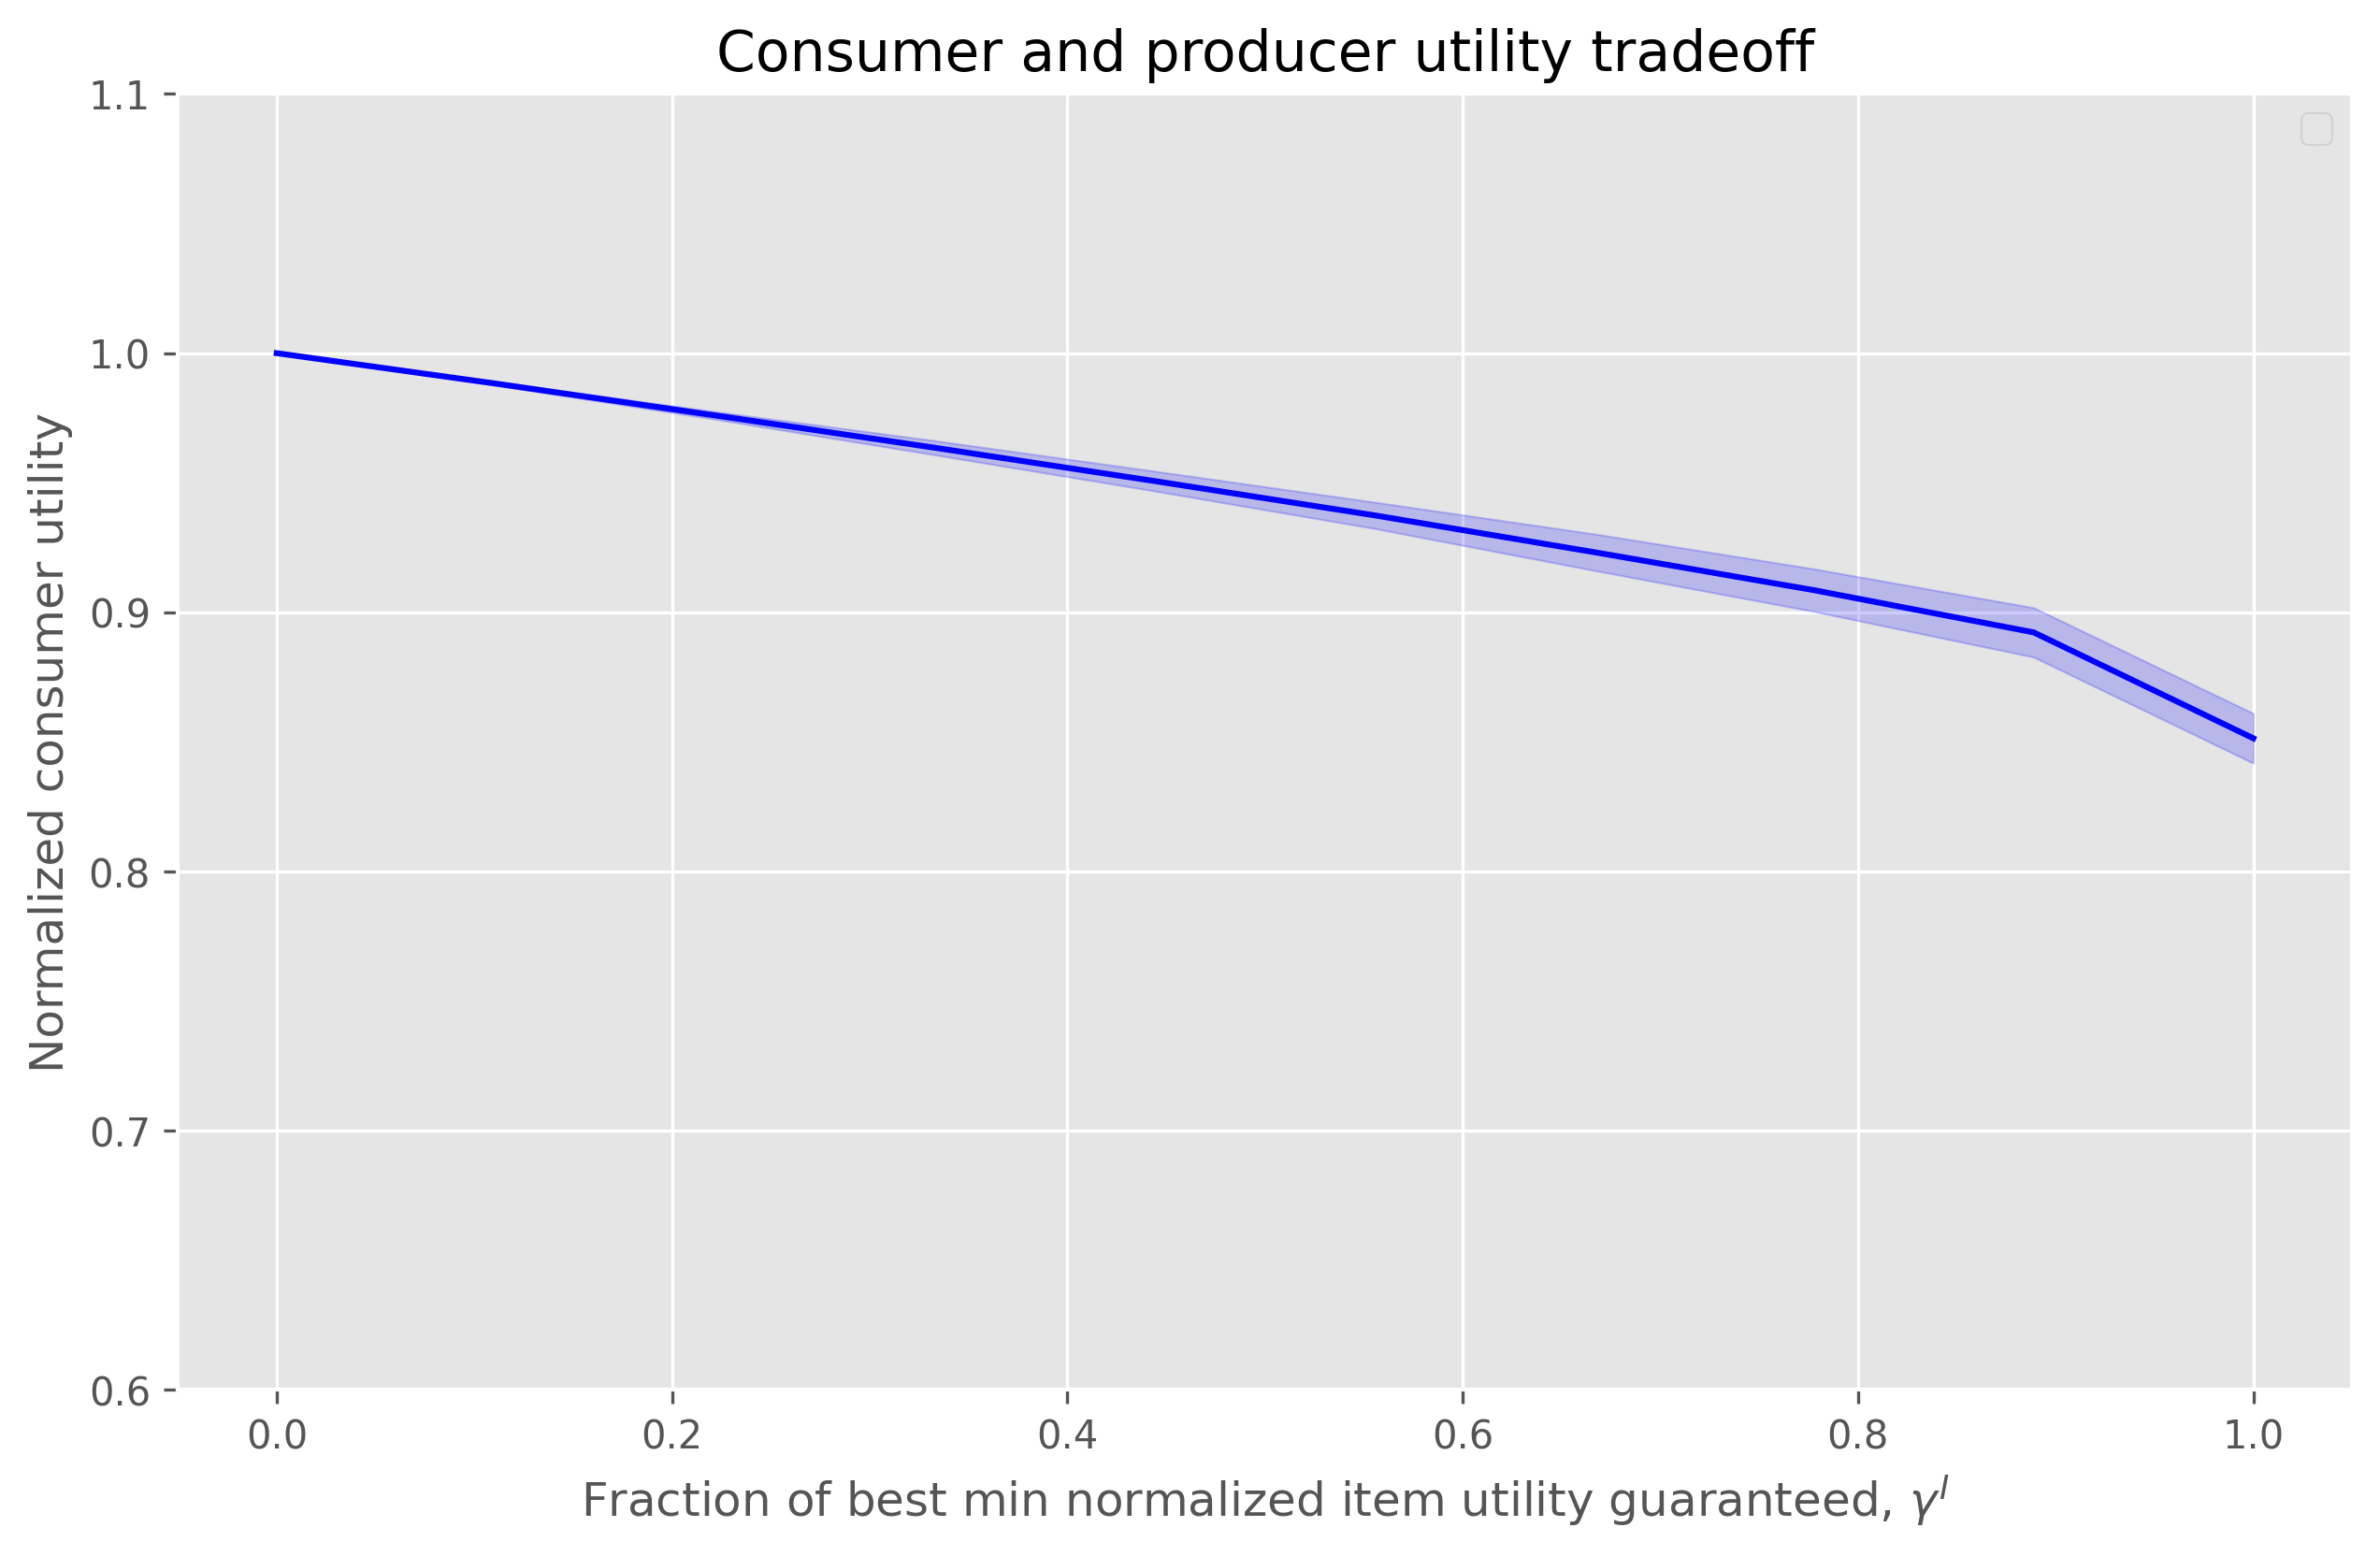

In [13]:
plt.figure(figsize=(10,6), dpi=300)
plt.plot(gammas, mean_tradeoff, color='blue')
plt.fill_between(gammas, mean_tradeoff - 2*std_tradeoff / np.sqrt(num_curves), mean_tradeoff + 2*std_tradeoff / np.sqrt(num_curves), color='blue', alpha=0.2)

plt.ylabel('Normalized consumer utility')
plt.xlabel(r'Fraction of best min normalized item utility guaranteed, $\gamma^I$')
plt.title("Consumer and producer utility tradeoff")
plt.legend()
plt.ylim([0.6,1.1])
plt.savefig("./media9/tradeoff_curves.png")

100%|██████████| 3/3 [05:11<00:00, 103.99s/it]


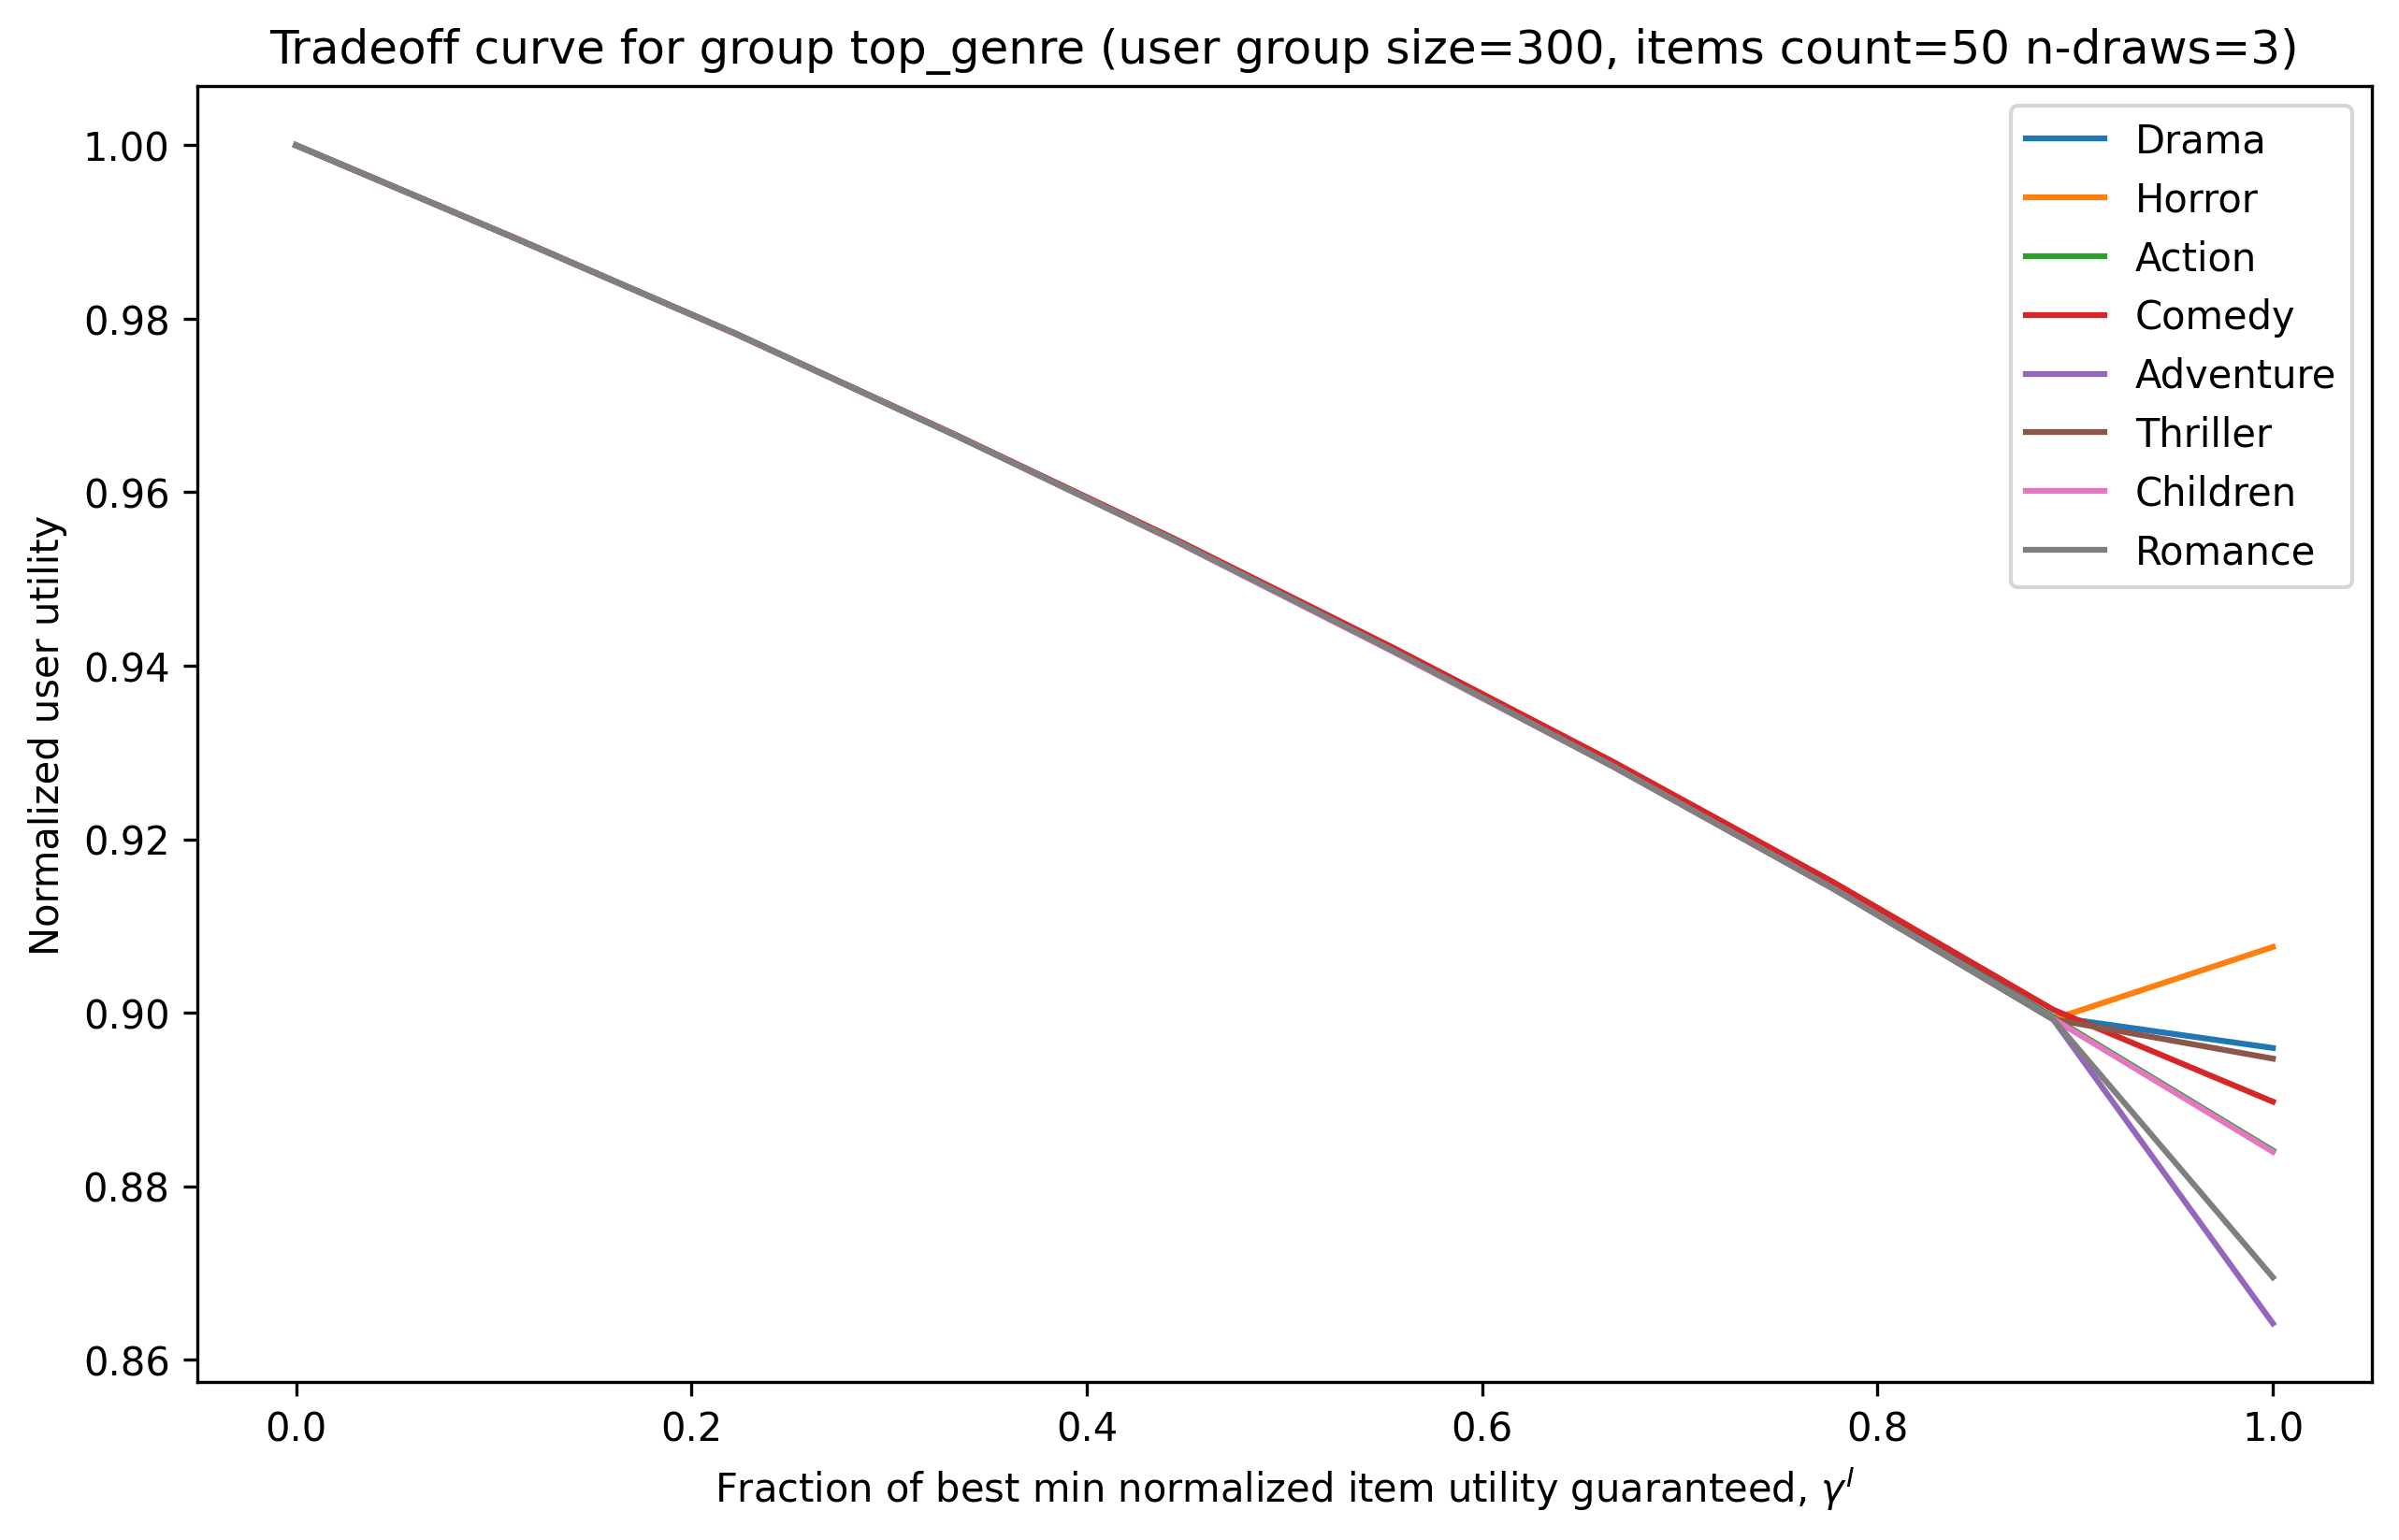

In [41]:
GROUP_NAME = "top_genre"

sample_n = 50
num_curves = 3
num_pts = 10
user_size = 300
delta = 1
k = 1

all_empirical_pairs, users_ids, u_utils = get_curves_user_groups(W=W, sample_m=user_size, sample_n=sample_n, num_curves=num_curves, num_pts=num_pts, k=k, delta=delta, groups_map=user_groups, group_name=GROUP_NAME)

results = defaultdict(dict)
gammas = all_empirical_pairs[0,:,0]

for gamma in range(num_pts):
    group_utils_mean = defaultdict(list)
    for draw in range(num_curves):
        group_users = defaultdict(list)
        for row in user_groups:
            user_id = row["user_id"]
            if user_id in users_ids[draw]:
                group_users[row[GROUP_NAME]].append(users_ids[draw].index(user_id))

        for group, users in group_users.items():
            group_utils_mean[group].append(np.take(u_utils[draw][gamma], users).mean())

    for group, utils in group_utils_mean.items():
        results[group][gamma] = {"mean": np.mean(utils), "std": np.std(utils)}


plt.figure(figsize=(10,6), dpi=300)
for group, data in results.items():
    plt.plot(gammas, [i["mean"] for i in data.values()], label=group)
    # plt.fill_between(gammas, [i["mean"] - 2*i["std"] / np.sqrt(num_curves) for i in data.values()], [i["mean"] + 2*i["std"] / np.sqrt(num_curves) for i in data.values()], alpha=0.2)

plt.legend()
plt.ylabel('Normalized user utility')
plt.title(f"Tradeoff curve for group {GROUP_NAME} (user group size={user_size}, items count={sample_n} n-draws={num_curves})")
plt.xlabel(r'Fraction of best min normalized item utility guaranteed, $\gamma^I$')
plt.savefig(f"./media_3/tradeoff_curves_{num_curves}_and_{user_size}_users_per_{GROUP_NAME}_{sample_n}_items.png")


In [37]:
results

defaultdict(dict,
            {'Drama': {0: {'mean': np.float64(1.0), 'std': np.float64(0.0)},
              1: {'mean': np.float64(0.9887199802570086),
               'std': np.float64(0.0014790438375996598)},
              2: {'mean': np.float64(0.9773152306798858),
               'std': np.float64(0.0029630880991300783)},
              3: {'mean': np.float64(0.9657163419450967),
               'std': np.float64(0.004397876692991255)},
              4: {'mean': np.float64(0.9536200531534211),
               'std': np.float64(0.00592338962336471)},
              5: {'mean': np.float64(0.9410919886823065),
               'std': np.float64(0.00734363865717766)},
              6: {'mean': np.float64(0.927863054719911),
               'std': np.float64(0.008827964415200337)},
              7: {'mean': np.float64(0.9140807772528533),
               'std': np.float64(0.010338440364865571)},
              8: {'mean': np.float64(0.8993873811541014),
               'std': np.float64(0.01176048

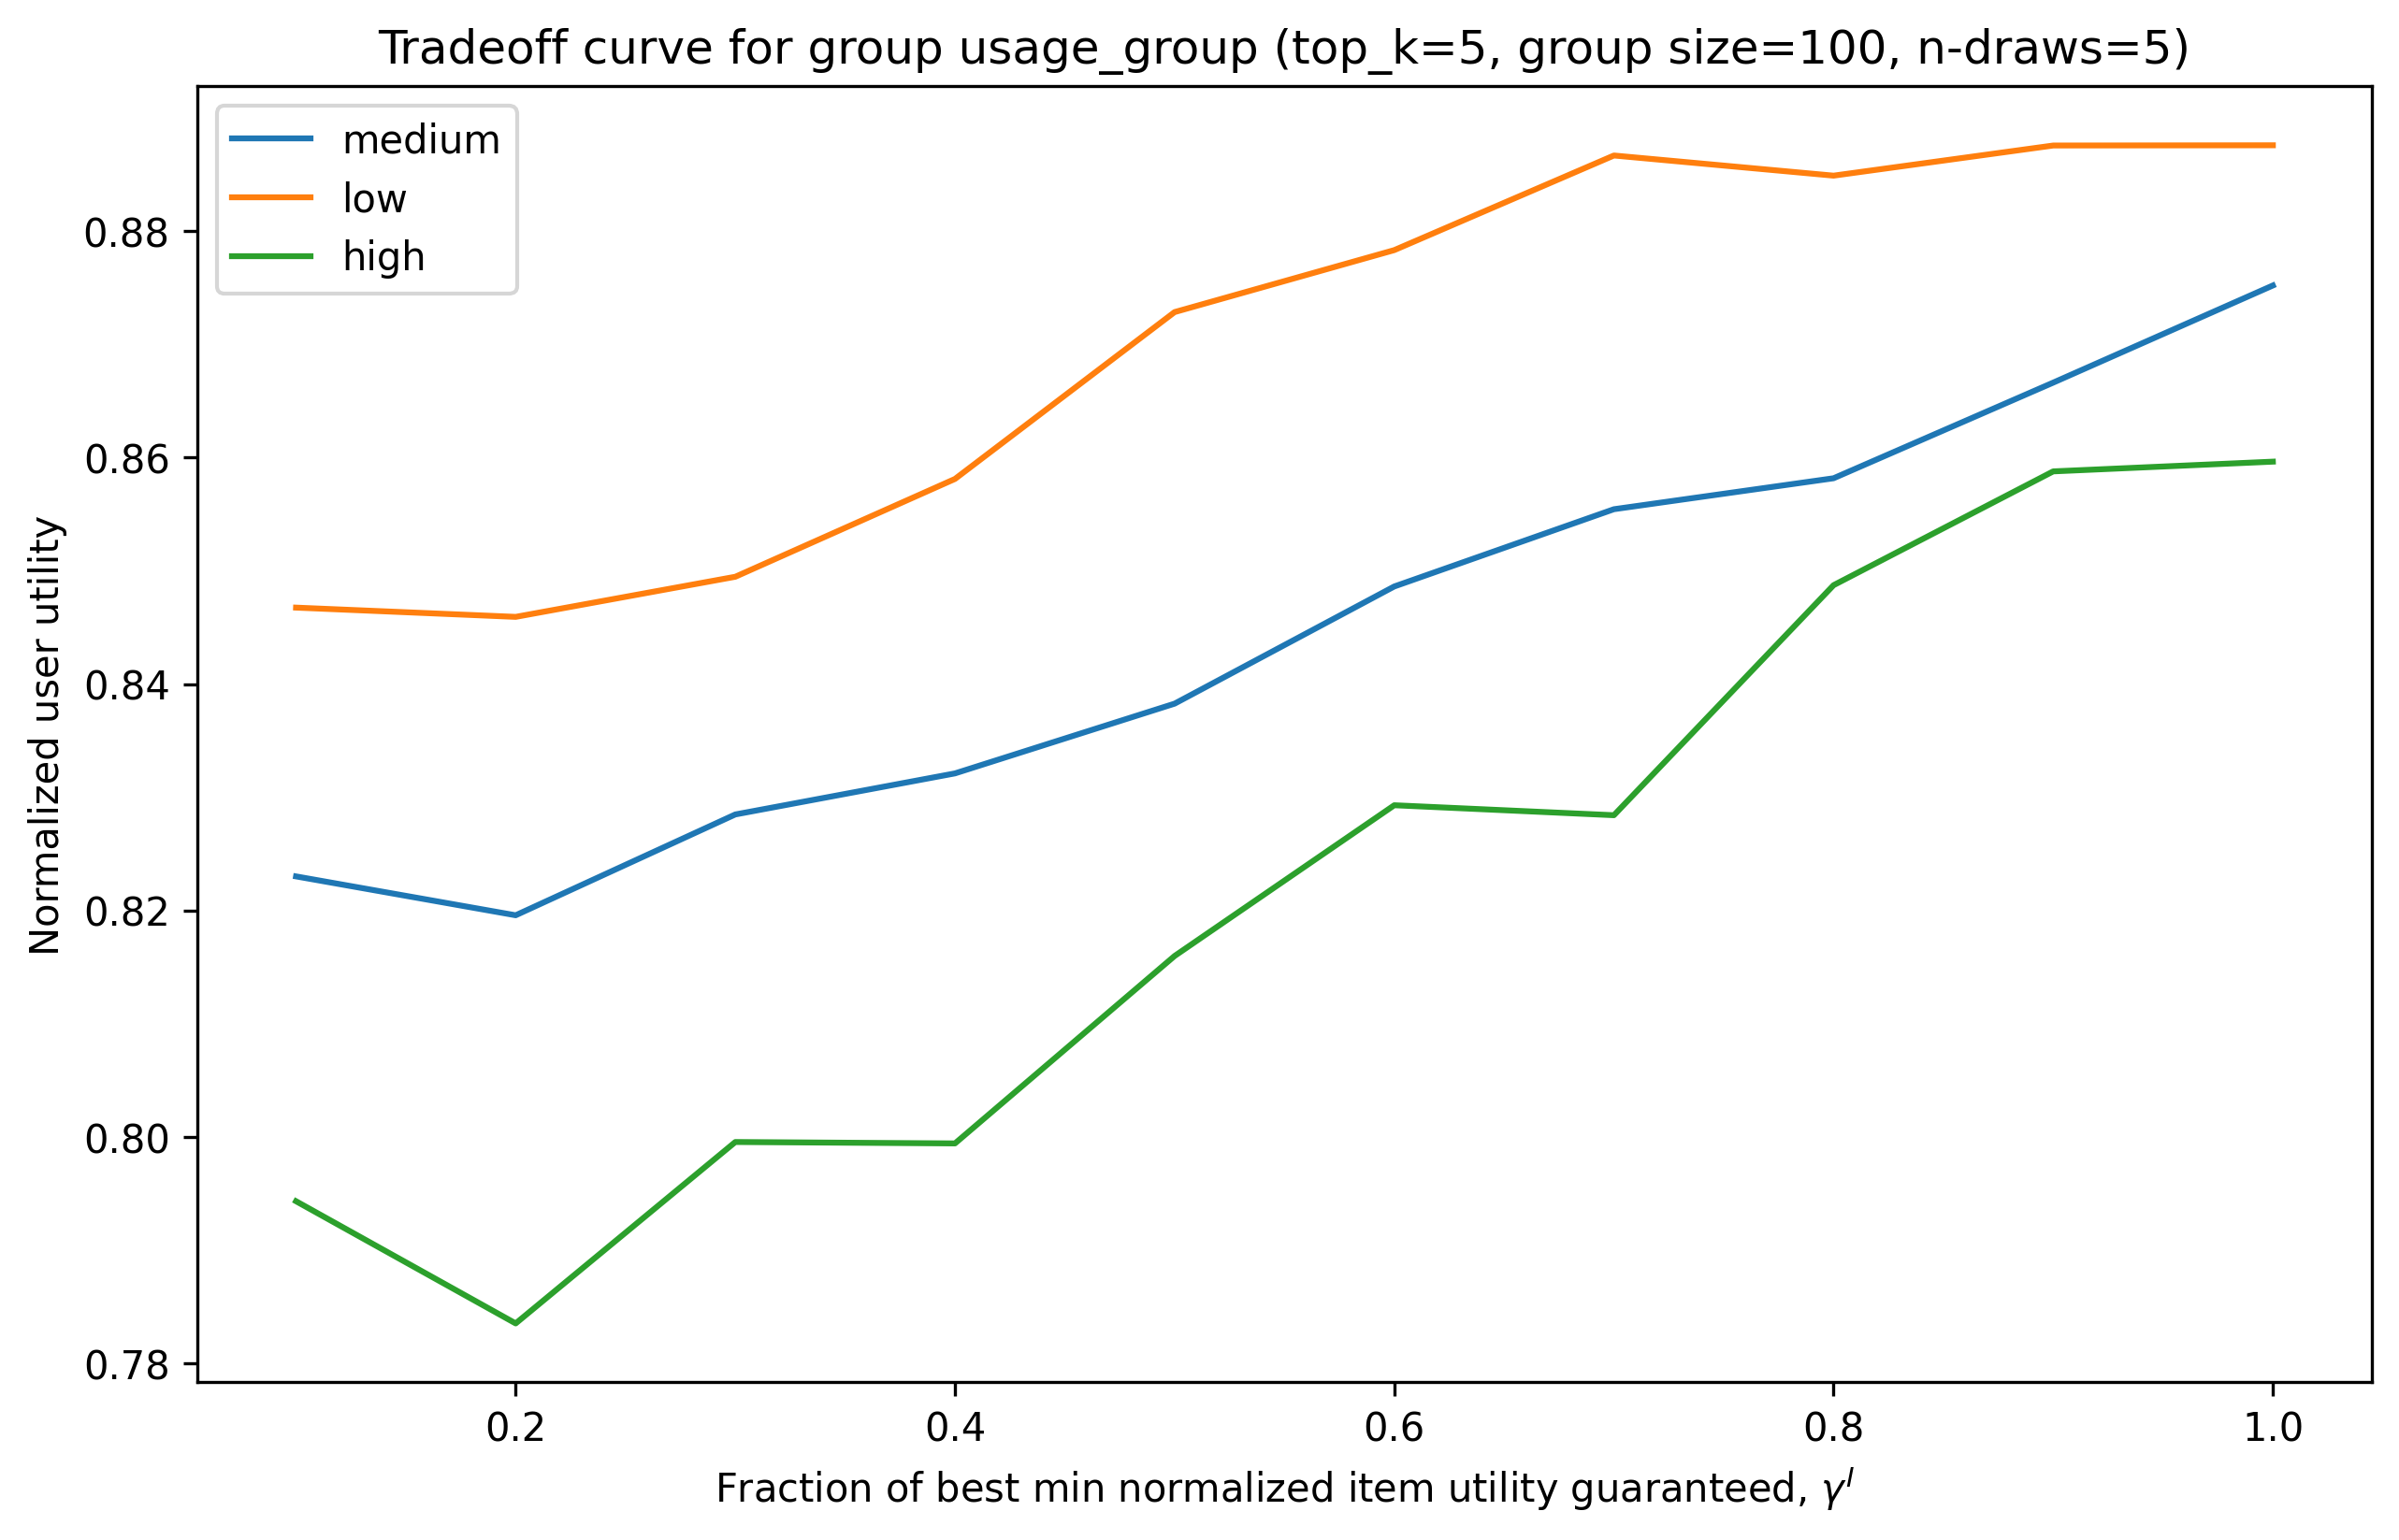

In [101]:
plt.figure(figsize=(10,6), dpi=300)
for group, data in results.items():
    plt.plot(gammas, [i["mean"] for i in data.values()], label=group)
    #plt.fill_between(gammas, [i["mean"] - 2*i["std"] / np.sqrt(num_curves) for i in data.values()], [i["mean"] + 2*i["std"] / np.sqrt(num_curves) for i in data.values()], alpha=0.2)

plt.legend()
plt.ylabel('Normalized user utility')
plt.title(f"Tradeoff curve for group {GROUP_NAME} (top_k={5}, group size={100}, n-draws={num_curves})")
plt.xlabel(r'Fraction of best min normalized item utility guaranteed, $\gamma^I$')
plt.savefig(f"./media_2/tradeoff_curves_topk_{1}_{num_curves}_and_{50}_users_per_{GROUP_NAME}.png")

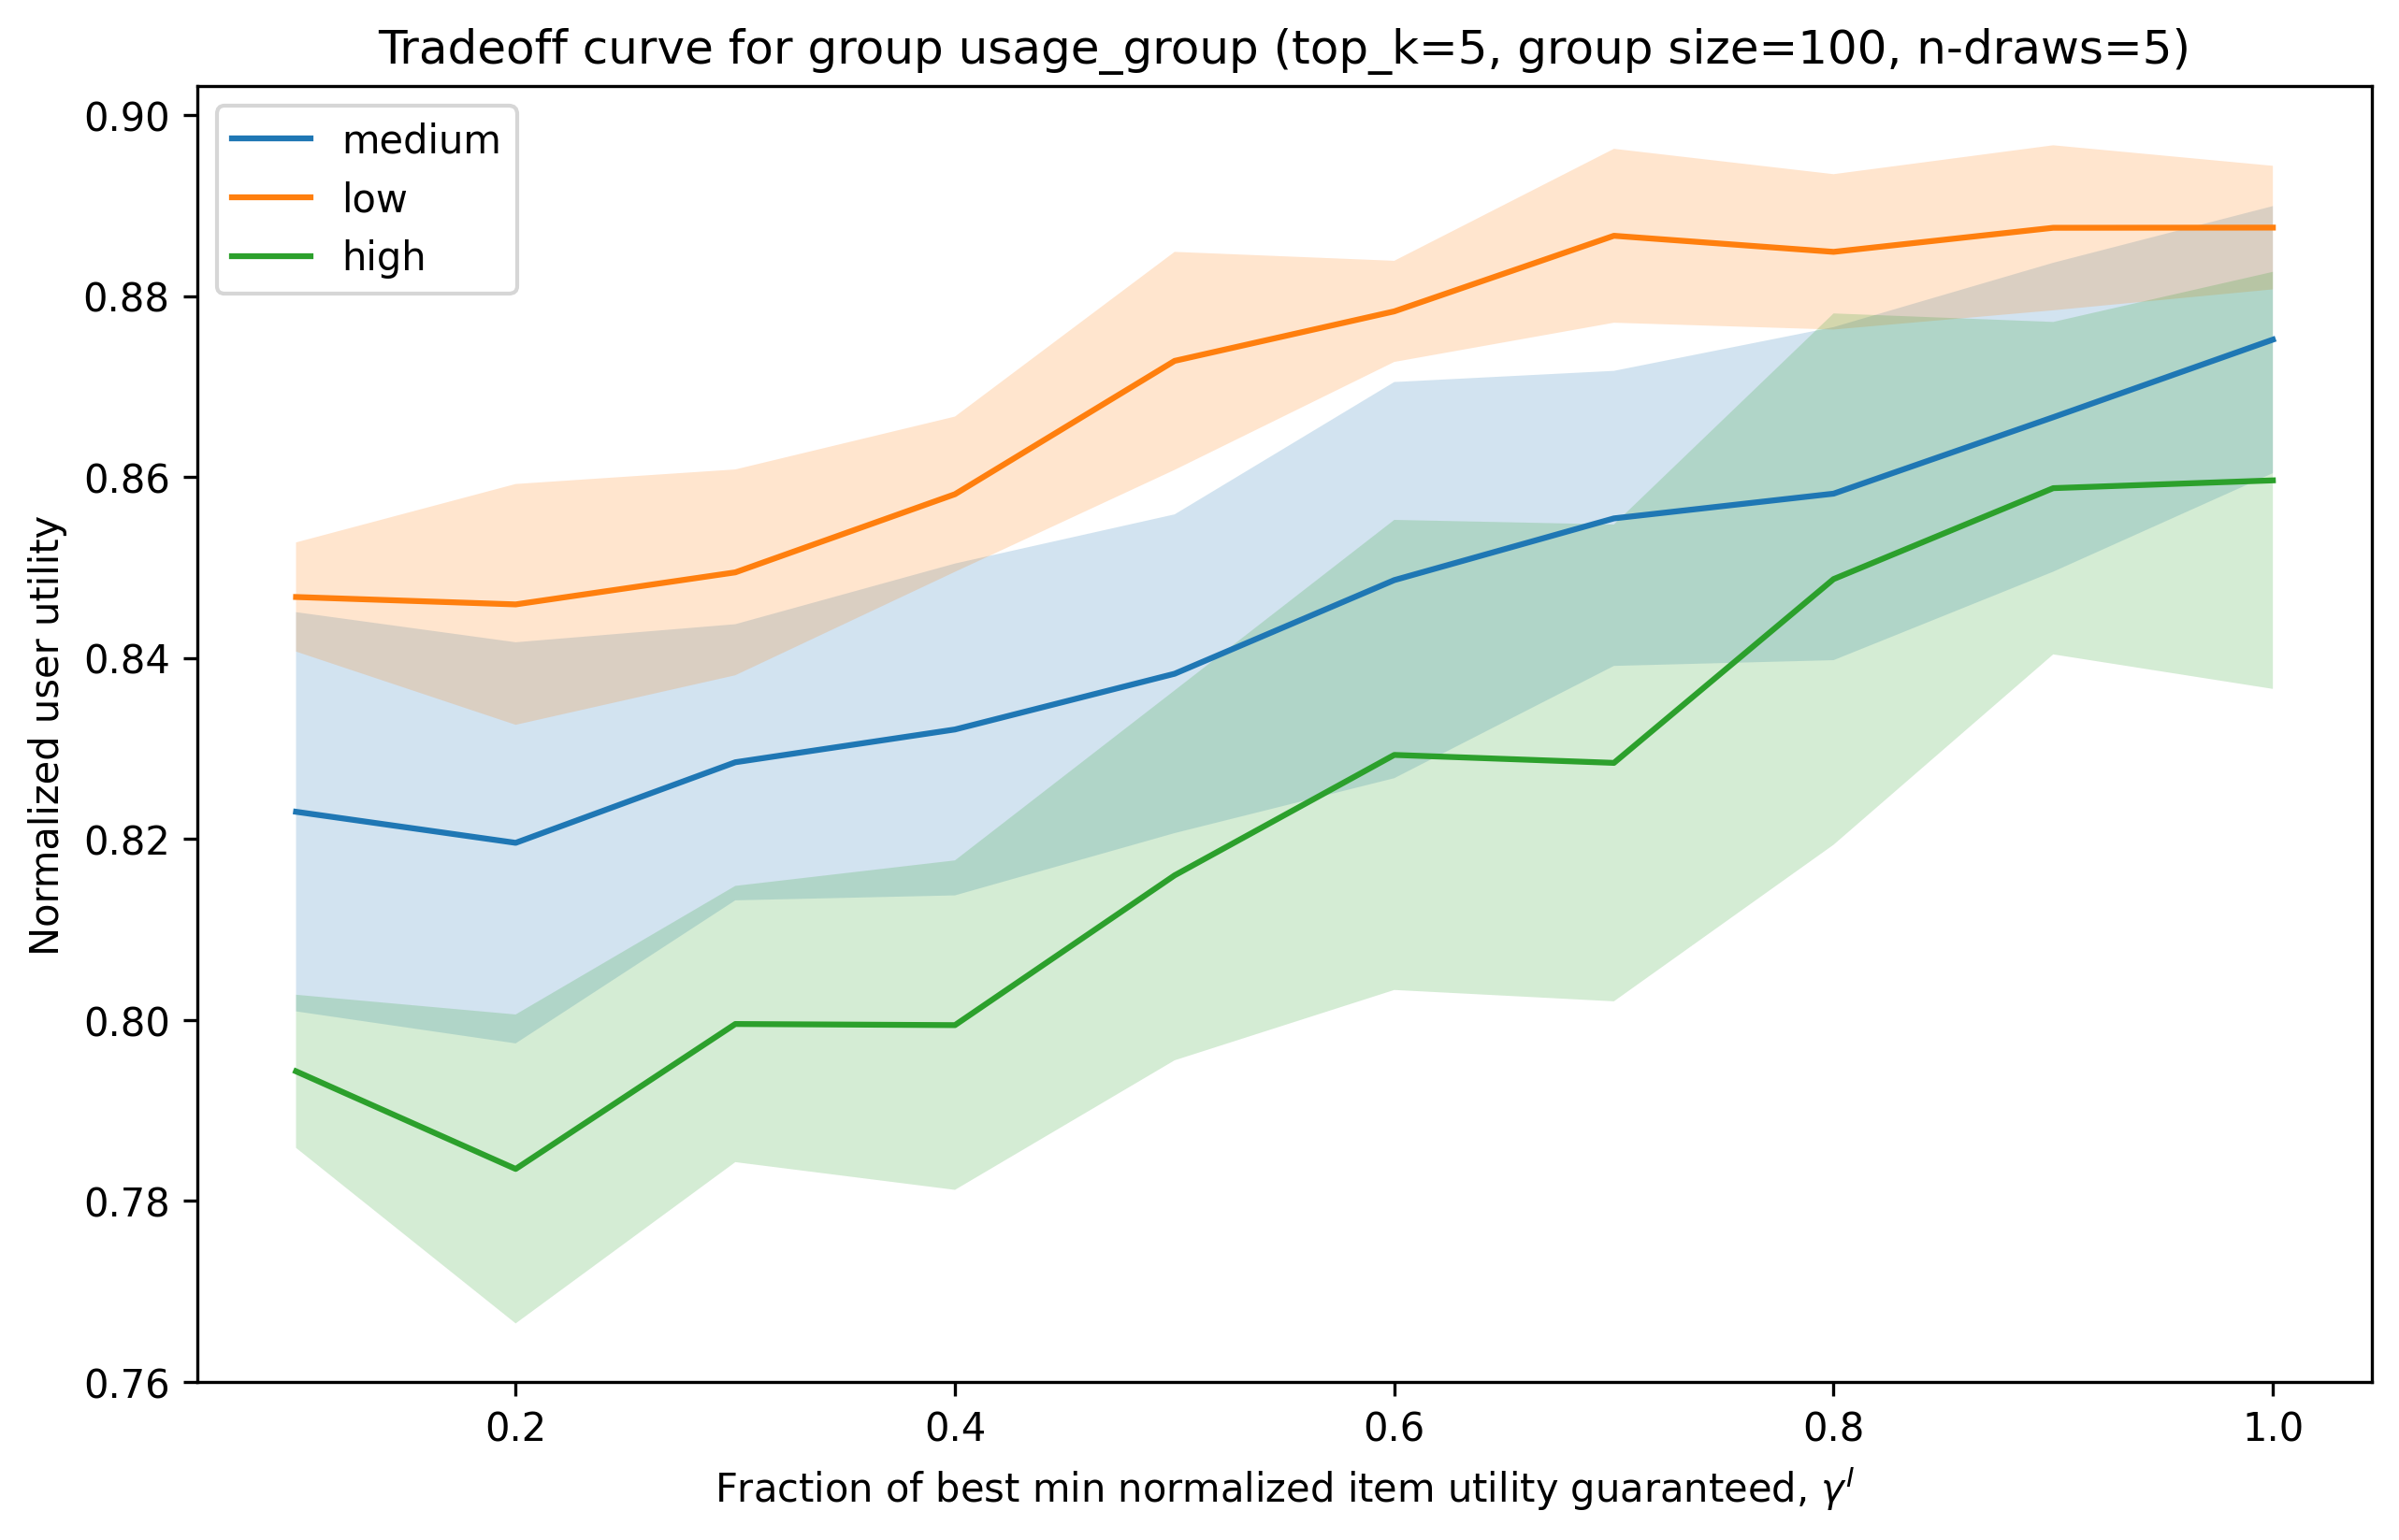

In [99]:
plt.figure(figsize=(10,6), dpi=300)
for group, data in results.items():
    plt.plot(gammas, [i["mean"] for i in data.values()], label=group)
    plt.fill_between(gammas, [i["mean"] - 2*i["std"] / np.sqrt(num_curves) for i in data.values()], [i["mean"] + 2*i["std"] / np.sqrt(num_curves) for i in data.values()], alpha=0.2)

plt.legend()
plt.ylabel('Normalized user utility')
plt.title(f"Tradeoff curve for group {GROUP_NAME} (top_k={5}, group size={100}, n-draws={num_curves})")
plt.xlabel(r'Fraction of best min normalized item utility guaranteed, $\gamma^I$')
plt.savefig(f"./media_2/tradeoff_curves_topk_{1}_{num_curves}_and_{50}_users_per_{GROUP_NAME}_std.png")

In [124]:
a = np.array([[1,2,3,4,5], [1,2,3,4,5]])


a[np.arange(a.shape[0])[:, None], np.argsort(a, axis=1)[:,-2:]].sum(axis=1)

array([9, 9])

In [121]:
all_empirical_pairs

array([[[0.1       , 0.99019078],
        [0.2       , 0.98023893],
        [0.3       , 0.97019518],
        [0.4       , 0.95998031],
        [0.5       , 0.94954169],
        [0.6       , 0.93876285],
        [0.7       , 0.92766151],
        [0.8       , 0.91625869],
        [0.9       , 0.90388615],
        [1.        , 0.89048751]],

       [[0.1       , 0.98950661],
        [0.2       , 0.97910475],
        [0.3       , 0.96860998],
        [0.4       , 0.95797767],
        [0.5       , 0.94673901],
        [0.6       , 0.935898  ],
        [0.7       , 0.92414604],
        [0.8       , 0.91237471],
        [0.9       , 0.89955587],
        [1.        , 0.88519718]],

       [[0.1       , 0.98692492],
        [0.2       , 0.97526369],
        [0.3       , 0.96287853],
        [0.4       , 0.95021478],
        [0.5       , 0.93746781],
        [0.6       , 0.92434423],
        [0.7       , 0.9108816 ],
        [0.8       , 0.89684434],
        [0.9       , 0.88222359],
        [1

In [ ]:
for gamma in range(num_pts):
    group_utils_mean = defaultdict(list)
    for draw in range(num_curves):
        group_users = defaultdict(list)
        for row in user_groups:
            user_id = row["user_id"]
            if user_id in users_ids[draw]:
                group_users[row[GROUP_NAME]].append(users_ids[draw].index(user_id))

        for group, users in group_users.items():
            group_utils_mean[group].append(np.take(u_utils[draw][gamma], users).mean())

    for group, utils in group_utils_mean.items():
        results[group][gamma] = {"mean": np.mean(utils), "std": np.std(utils)}

In [ ]:
import cvxpy as cp

X_u = cp.Variable((10, 10), boolean=True)